In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [29]:
# Loading the Dataset
data_path = '/content/Augmented_Spaghetti_Dataset_1(1).xlsx'
data = pd.read_excel(data_path)


In [30]:
columns = [
    'Bridge ID', 'Bridge Width (m)', 'Bridge Height (m)', 'Cross-Sectional Diameter (m)', 'Cross-Sectional Area (m²)',
    'Cross-Sectional Moment of Inertia (m⁴)', 'Number of Strands', 'Number of Beams', 'Angle of Inclination (°)',
    'Angle of Declination (°)', 'Symmetry', 'Joint Design', 'Young’s Modulus (Pa)', 'Poisson’s Ratio', 'Density (kg/m³)',
    'Tensile Yield Strength (Pa)', 'Shear Modulus (Pa)', 'Applied Force (N)', 'Load Location (x, y, z)',
    'Load Type', 'Support Type', 'Support Locations', 'Mesh Elements', 'Mesh Density (elements/m³)',
    'Element Type', 'Max Equivalent Stress (Pa)', 'Max Principal Stress (Pa)', 'Min/Max Deformation (m)',
    'Safety Factor', 'Reaction Forces (N)', 'Strain Energy (J)', 'Work Done (J)', 'Energy Residual (J)',
    'Yield Constraint Residual', 'Max Failure Load (N)'
]

In [32]:
numeric_columns = [
    'Bridge Width (m)', 'Bridge Height (m)', 'Cross-Sectional Diameter (m)', 'Cross-Sectional Area (m²)',
    'Cross-Sectional Moment of Inertia (m⁴)', 'Number of Strands', 'Number of Beams', 'Angle of Inclination (°)',
    'Angle of Declination (°)', 'Young’s Modulus (Pa)', 'Poisson’s Ratio', 'Density (kg/m³)',
    'Tensile Yield Strength (Pa)', 'Shear Modulus (Pa)', 'Mesh Elements', 'Mesh Density (elements/m³)',
    'Max Equivalent Stress (Pa)', 'Max Principal Stress (Pa)', 'Min/Max Deformation (m)', 'Safety Factor',
    'Strain Energy (J)', 'Work Done (J)', 'Energy Residual (J)', 'Yield Constraint Residual', 'Max Failure Load (N)'
]

In [35]:
def convert_to_numeric(value):
    try:
        # Convert string representations of lists to the first element
        if isinstance(value, str) and value.startswith('['):
            value = eval(value)[0]
        return float(value)
    except:
        return np.nan

for column in numeric_columns:
    data[column] = data[column].apply(convert_to_numeric)

In [39]:
# Drop rows with NaNs in numeric columns only
data = data.dropna(subset=numeric_columns + ['Max Failure Load (N)'])

# Check the dataset after conversion
print("Data after conversion to numeric:")
print(data.head())

X = data[numeric_columns].values.astype(np.float32)
y = data['Max Failure Load (N)'].values.astype(np.float32)

# Print the number of samples and features after cleaning
print(f"Number of samples: {len(data)}")
print(f"Number of features: {len(numeric_columns)}")

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

Data after conversion to numeric:
   Bridge ID  Bridge Width (m)  Bridge Height (m)  \
0          1          0.254000           0.254000   
1          2          0.229931           0.254385   
2          3          0.257660           0.261869   
3          4          0.261821           0.261837   
4          5          0.259379           0.261241   

   Cross-Sectional Diameter (m)  Cross-Sectional Area (m²)  \
0                      0.012000                   0.012000   
1                      0.013045                   0.012322   
2                      0.012049                   0.011541   
3                      0.011801                   0.012437   
4                      0.012579                   0.010882   

   Cross-Sectional Moment of Inertia (m⁴)  Number of Strands  Number of Beams  \
0                            1.017000e-09                6.0             13.0   
1                            1.040321e-09                6.0             11.0   
2                            1.

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Define the Physics-Informed Neural Network (PINN) model
class PINN(Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = Dense(128, activation='relu')
        self.bn1 = BatchNormalization()
        self.dropout1 = Dropout(0.2)
        self.dense2 = Dense(128, activation='relu')
        self.bn2 = BatchNormalization()
        self.dropout2 = Dropout(0.2)
        self.dense3 = Dense(64, activation='relu')
        self.bn3 = BatchNormalization()
        self.dropout3 = Dropout(0.2)
        self.dense4 = Dense(64, activation='relu')
        self.bn4 = BatchNormalization()
        self.dropout4 = Dropout(0.2)
        self.dense5 = Dense(32, activation='relu')
        self.bn5 = BatchNormalization()
        self.output_layer = Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.dense4(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.dense5(x)
        x = self.bn5(x)
        output = self.output_layer(x)
        return output

    def physics_loss(self, X, y_pred):
        # Implement the physical laws here

        # Euler-Bernoulli Beam Equation
        E = X[:, 9]  # Young’s Modulus (Pa)
        I = X[:, 5]  # Cross-Sectional Moment of Inertia (m⁴)
        w = y_pred[:, 0]
        q = -X[:, 16] / X[:, 6]  # Applied Force (N) / Number of Strands
        beam_eq = E * I * w - q

        # Axial Stress
        A = X[:, 4]  # Cross-Sectional Area (m²)
        F = X[:, 16]  # Applied Force (N)
        axial_stress = F / A

        # Axial Deformation
        L = X[:, 2]  # Bridge Height (m)
        axial_deformation = (F * L) / (A * E)

        # Shear Modulus Relationship
        ν = X[:, 10]  # Poisson’s Ratio
        G = E / (2 * (1 + ν))

        # Von Mises Yield Criterion
        σ_yield = X[:, 12]  # Tensile Yield Strength (Pa)
        σ_1 = X[:, 18]  # Max Principal Stress (Pa)
        σ_2 = X[:, 18]
        σ_3 = X[:, 18]
        von_mises = np.sqrt((σ_1 - σ_2)**2 + (σ_2 - σ_3)**2 + (σ_3 - σ_1)**2) / 2 - σ_yield

        # Hooke's Law
        ε = axial_deformation / L
        hookes_law = E * ε - axial_stress

        # Shear Stress-Strain Relationship
        τ = X[:, 18]  # Max Principal Stress (Pa)
        γ = τ / G
        shear_stress_strain = τ - G * γ

        # Poisson's Effect
        ε_lateral = -ν * ε

        # Principal Stresses
        σ_x = X[:, 18]
        σ_y = X[:, 18]
        τ_xy = τ
        principal_stresses = (σ_x + σ_y) / 2 + np.sqrt((σ_x - σ_y)**2 / 4 + τ_xy**2)

        # Force Equilibrium
        F_x = X[:, 16]
        F_y = X[:, 16]
        F_z = X[:, 16]
        force_eq = F_x + F_y + F_z

        # Moment Equilibrium
        M_x = X[:, 18]
        M_y = X[:, 18]
        M_z = X[:, 18]
        moment_eq = M_x + M_y + M_z

        # Torsional Shear Stress
        r = X[:, 3] / 2  # Cross-Sectional Diameter (m) / 2
        J = I  # Using Moment of Inertia as an approximation for Polar Moment of Inertia
        T = F * r  # Torque is force times radius
        torsional_shear_stress = np.divide(T * r, J, out=np.zeros_like(T * r), where=J!=0)

        # Angle of Twist
        angle_of_twist = np.divide(T * L, G * J, out=np.zeros_like(T * L), where=(G * J)!=0)

        # Euler Critical Load (Buckling)
        K = 1  # Effective length factor
        euler_critical_load = (np.pi**2 * E * I) / ((K * L)**2)

        # Lateral-Torsional Buckling Critical Moment
        I_y = I  # Moment of Inertia in y
        lateral_torsional_buckling = np.divide((np.pi / L) * np.sqrt(E * I_y * G * J), 1, out=np.zeros_like(E * I_y * G * J), where=L!=0)

        # Strain Energy Density
        strain_energy_density = (axial_stress * ε) / 2

        # Total physics loss
        physics_loss = tf.reduce_mean(tf.square(beam_eq)) + tf.reduce_mean(tf.square(axial_stress)) + \
                       tf.reduce_mean(tf.square(axial_deformation)) + tf.reduce_mean(tf.square(G)) + \
                       tf.reduce_mean(tf.square(von_mises)) + tf.reduce_mean(tf.square(hookes_law)) + \
                       tf.reduce_mean(tf.square(shear_stress_strain)) + tf.reduce_mean(tf.square(ε_lateral)) + \
                       tf.reduce_mean(tf.square(principal_stresses)) + tf.reduce_mean(tf.square(force_eq)) + \
                       tf.reduce_mean(tf.square(moment_eq)) + tf.reduce_mean(tf.square(torsional_shear_stress)) + \
                       tf.reduce_mean(tf.square(angle_of_twist)) + tf.reduce_mean(tf.square(euler_critical_load)) + \
                       tf.reduce_mean(tf.square(lateral_torsional_buckling)) + tf.reduce_mean(tf.square(strain_energy_density))

        return physics_loss

# Create the PINN model
model = PINN()



In [69]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [70]:
loss_history = []
physics_loss_history = []
data_loss_history = []

In [73]:
def train_step(X, y):
    with tf.GradientTape() as tape:
        predictions = model(X, training=True)
        data_loss = tf.keras.losses.MeanSquaredError()(y, predictions)
        physics_loss = model.physics_loss(X, predictions)
        total_loss = 0.7 * data_loss + 0.3 * physics_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Track losses
    loss_history.append(total_loss.numpy())
    physics_loss_history.append(physics_loss.numpy())
    data_loss_history.append(data_loss.numpy())

    return total_loss

In [83]:
epochs = 80
batch_size = 8
num_batches = len(X_train) // batch_size

for epoch in range(epochs):
    for batch in range(num_batches):
        X_batch = X_train[batch * batch_size:(batch + 1) * batch_size]
        y_batch = y_train[batch * batch_size:(batch + 1) * batch_size]
        total_loss = train_step(X_batch, y_batch)
    print(f'Epoch {epoch + 1}, Loss: {total_loss.numpy()/1000}')

# Save the trained model
model.save('pinn_model.h5')

Epoch 1, Loss: 11.925742149353027
Epoch 2, Loss: 11.941384315490723
Epoch 3, Loss: 11.932791709899902
Epoch 4, Loss: 11.938547134399414
Epoch 5, Loss: 11.957386016845703
Epoch 6, Loss: 11.926218032836914
Epoch 7, Loss: 11.976461410522461
Epoch 8, Loss: 11.933313369750977
Epoch 9, Loss: 11.978965759277344
Epoch 10, Loss: 11.9774169921875
Epoch 11, Loss: 11.941656112670898
Epoch 12, Loss: 12.00837230682373
Epoch 13, Loss: 11.933927536010742
Epoch 14, Loss: 12.018745422363281
Epoch 15, Loss: 11.927772521972656
Epoch 16, Loss: 11.992254257202148
Epoch 17, Loss: 11.926896095275879
Epoch 18, Loss: 11.97348690032959
Epoch 19, Loss: 11.932271957397461
Epoch 20, Loss: 11.94852066040039
Epoch 21, Loss: 11.928236961364746
Epoch 22, Loss: 11.941269874572754
Epoch 23, Loss: 11.93110179901123
Epoch 24, Loss: 11.931541442871094
Epoch 25, Loss: 11.92833137512207
Epoch 26, Loss: 11.929878234863281
Epoch 27, Loss: 11.92995548248291
Epoch 28, Loss: 11.926481246948242
Epoch 29, Loss: 11.928179740905762
Ep

Epoch 80, Loss: 11.925751686096191


In [84]:
from sklearn.metrics import mean_absolute_error


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Test MSE: 100.6801528930664
Test R2: 0.9764334559440613
Mean Absolute Error (MAE): 7.722445011138916
Root Mean Squared Error (RMSE): 10.033950014479164


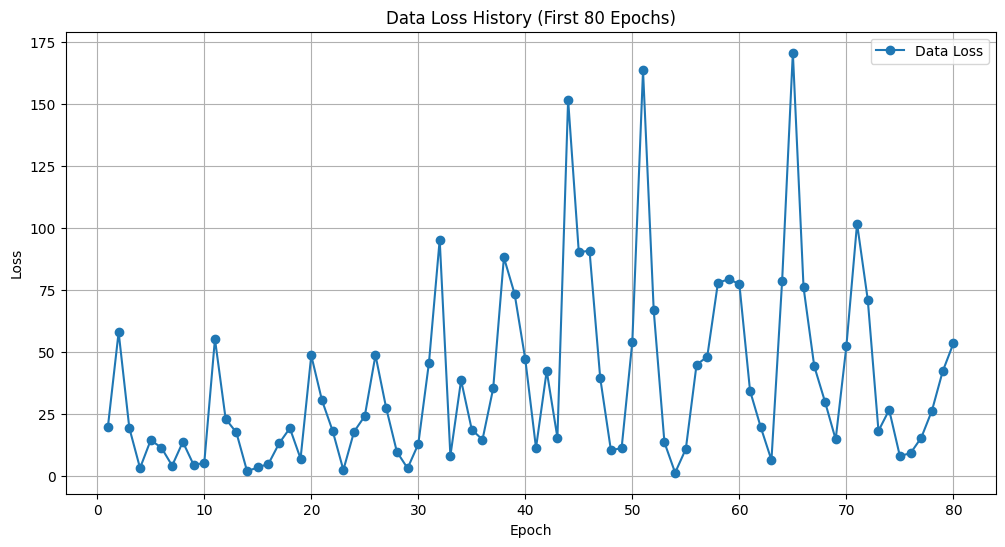

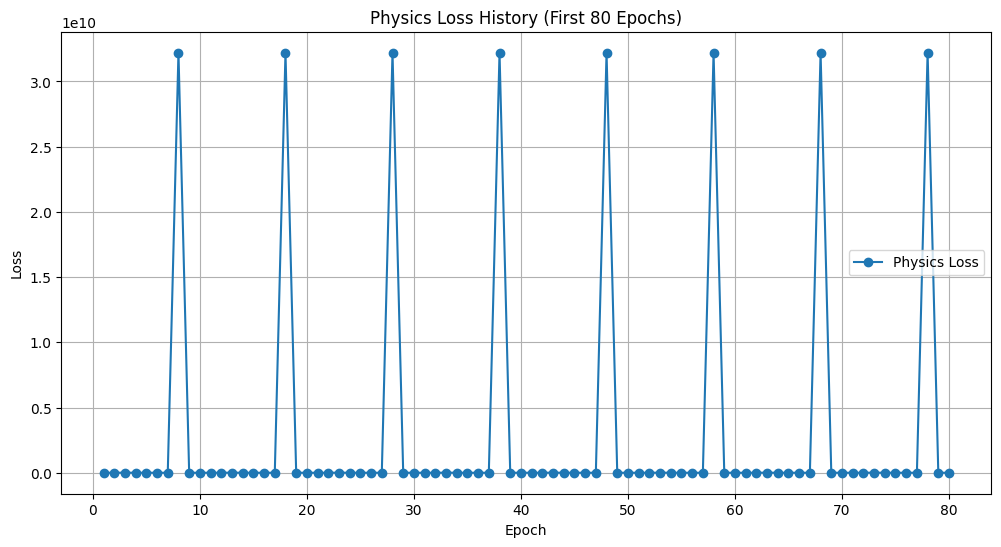

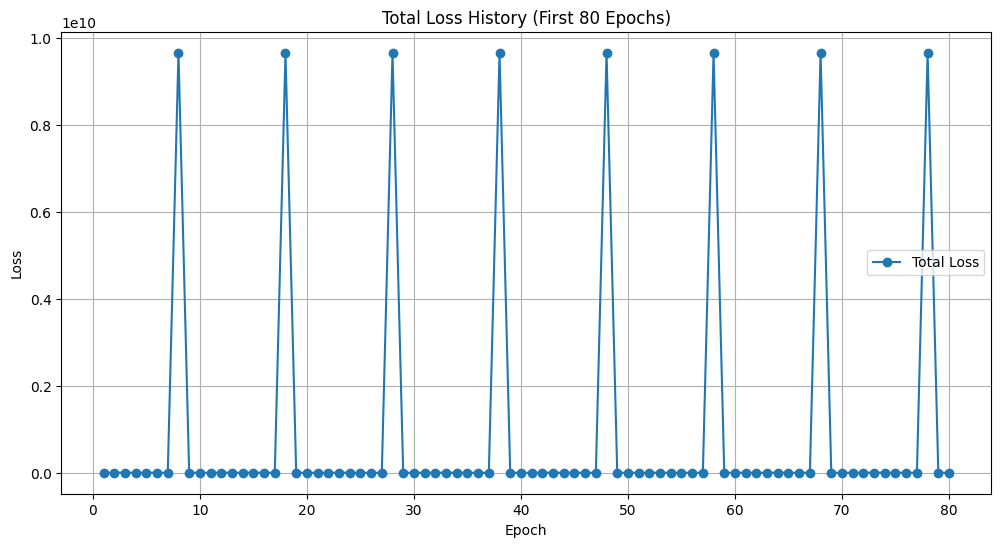

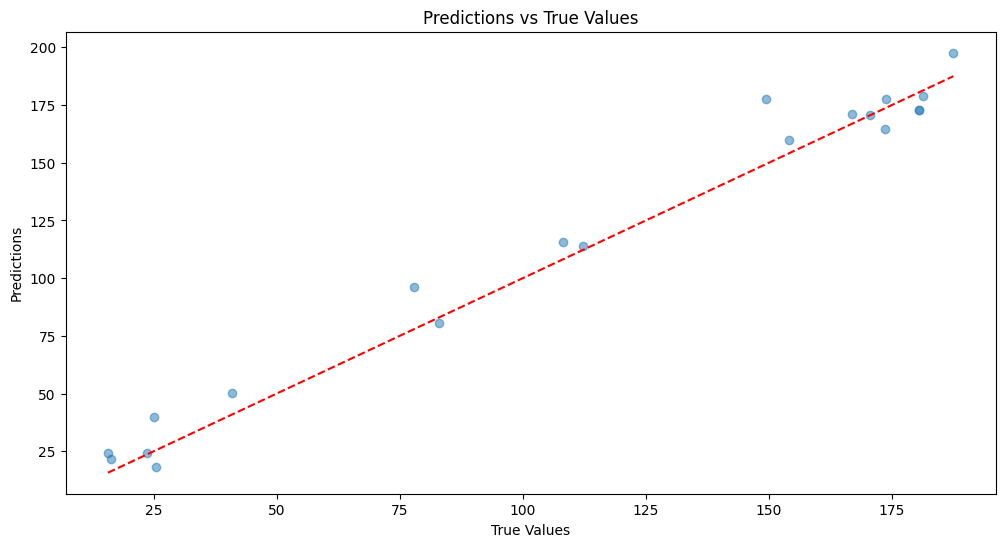

In [90]:

model.save('pinn_model.h5')

# Evaluating the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test MSE: {mse}')
print(f'Test R2: {r2}')

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)


rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


# Plot the loss history
import matplotlib.pyplot as plt

epochs = range(1, 81)  # Epochs from 1 to 80

# Save directory
save_path = "loss_plots/"

# Ensure the save directory exists
import os
os.makedirs(save_path, exist_ok=True)

# Plot and save Data Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, data_loss_history[:80], label='Data Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Data Loss History (First 80 Epochs)')
plt.grid(True)
plt.savefig(f"{save_path}data_loss.png", dpi=300, bbox_inches='tight')  # Save as high-quality image
plt.show()

# Plot and save Physics Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, physics_loss_history[:80], label='Physics Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Physics Loss History (First 80 Epochs)')
plt.grid(True)
plt.savefig(f"{save_path}physics_loss.png", dpi=300, bbox_inches='tight')  # Save as high-quality image
plt.show()

# Plot and save Total Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_history[:80], label='Total Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Total Loss History (First 80 Epochs)')
plt.grid(True)
plt.savefig(f"{save_path}total_loss.png", dpi=300, bbox_inches='tight')  # Save as high-quality image
plt.show()



# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.show()